# Experiment 1.3 XGBoost with class balancing

Try to improve on the xgboost model score by treating the class imbalance in the training data. Can do this by resampling using various techniques:

1. Use weights
2. Upsample or downsample
3. Synthetic Minority Oversampling Technique (SMOTE)

Experiments will be tried in this order (from least to most destructive)

Simple examples to follow

https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

https://elitedatascience.com/imbalanced-classes

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

The previous kaggle AUC to beat is 0.70615. 
The best validation AUC so far is 0.70257.

In [4]:
pip install xgboost

     |████████████████████████████████| 157.5 MB 2.9 kB/s eta 0:00:01   |▍                               | 1.9 MB 3.6 MB/s eta 0:00:44     |█▍                              | 6.8 MB 4.3 MB/s eta 0:00:36     |█▌                              | 7.3 MB 4.3 MB/s eta 0:00:36     |█▉                              | 9.1 MB 4.3 MB/s eta 0:00:35     |██                              | 9.8 MB 4.3 MB/s eta 0:00:35     |███▏                            | 15.4 MB 6.2 MB/s eta 0:00:23     |███▋                            | 17.5 MB 6.2 MB/s eta 0:00:23     |█████                           | 24.9 MB 8.4 MB/s eta 0:00:16     |██████▋                         | 32.7 MB 292 kB/s eta 0:07:07     |███████                         | 34.4 MB 292 kB/s eta 0:07:01     |███████                         | 34.8 MB 7.4 MB/s eta 0:00:17     |███████▋                        | 37.2 MB 7.4 MB/s eta 0:00:17     |███████▊                        | 37.9 MB 7.4 MB/s eta 0:00:17     |████████▏                       | 40.0 MB 7.4 MB

In [5]:
pip install imblearn

     |████████████████████████████████| 167 kB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 22.3 MB 75 kB/s  eta 0:00:01    |█▏                              | 839 kB 6.2 MB/s eta 0:00:04     |████▏                           | 2.9 MB 6.2 MB/s eta 0:00:04     |████▊                           | 3.3 MB 6.2 MB/s eta 0:00:04     |██████▏                         | 4.3 MB 6.2 MB/s eta 0:00:03     |██████▊                         | 4.7 MB 6.2 MB/s eta 0:00:03     |████████▊                       | 6.0 MB 6.2 MB/s eta 0:00:03     |██████████▊                     | 7.4 MB 5.8 MB/s eta 0:00:03     |█████████████▏                  | 9.2 MB 5.8 MB/s eta 0:00:03     |██████████████▏                 | 9.9 MB 5.8 MB/s eta 0:00:03     |███████████████████▏            | 13.4 MB 5.8 MB/s eta 0:00:02     |███████████████████▊            | 13.7 MB 6.4 MB/s eta 0:00:02     |███████████████████████▏        | 16.1 MB 6.4 MB/s eta 0:00:01     |██████████████████████████▏     | 18.2 MB 6.4 MB/s e

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [7]:
# import load_data function from helper file 
%load_ext autoreload
%autoreload 2

# fix system path
import sys
sys.path.append("/home/jovyan/work")

In [8]:
from src.features.helper_functions import load_sets

X_train, y_train, X_val, y_val, X_test = load_sets()

Check the class counts again

In [12]:
# check distribution of the target
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1]
 [1074 5326]]


In [14]:
5362/1074

4.992551210428306

Ratio is 20% 0 to 1, so for the weights in xgboost use 
scale_pos_weight=5.

## Train using class weights
Use stratified kfold for cross validation - need to use this to assess the effectiveness of applying weights

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# create kfold object
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [16]:
# instatiate model
model = XGBClassifier(scale_pos_weight=5)

In [18]:
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=kfold, n_jobs=-1)

NameError: name 'mean' is not defined

In [19]:
# summarise performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.65223


Not the best AUC, but could be better.Try with the best parameters from previous grid search experiment, and also add in a range of weights to see if a different value is better.

In [21]:
# load previous model
from joblib import load
model_best_params = load('../models/rex_xgb_gridsearch.joblib')

In [22]:
from sklearn.model_selection import GridSearchCV

# define grid
weights = [2, 3, 4, 5]
param_grid = dict(scale_pos_weight=weights)

# define grid search
grid = GridSearchCV(estimator=model_best_params, param_grid=param_grid, n_jobs=-1, cv=kfold, scoring='roc_auc')

In [23]:
# execute the grid search
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.700503 using {'scale_pos_weight': 5}
0.699500 (0.027510) with: {'scale_pos_weight': 2}
0.700491 (0.027545) with: {'scale_pos_weight': 3}
0.700256 (0.027630) with: {'scale_pos_weight': 4}
0.700503 (0.027853) with: {'scale_pos_weight': 5}


The AUC sits just above 0.7, and just below the validation set AUC from the previous experiment. 
Let's try and make a prediction and see what the new validation AUC will be, using weight of 5.

In [25]:
# train model with weights and best params
model = XGBClassifier(max_depth = 2, n_estimators = 140, learning_rate = 0.05, scale_pos_weight=5)

In [26]:
model_weight_bp = model.fit(X_train, y_train)

[12:45:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
from src.features.helper_functions import save_model

In [30]:
save_model(model_weight_bp, 'rez_xgb_bestparam_weight')

Model saved succesfully


## Predict on val set

In [31]:
# predict class
y_train_preds = model_weight_bp.predict(X_train)
y_val_preds = model_weight_bp.predict(X_val)

In [32]:
# predict proabilities
y_train_preds_prob = model_weight_bp.predict_proba(X_train)
y_val_preds_prob = model_weight_bp.predict_proba(X_val)

In [33]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [34]:
print(mse(y_train, y_train_preds, squared=False))
print(mae(y_train, y_train_preds))

print(mse(y_val, y_val_preds, squared=False))
print(mae(y_val, y_val_preds))

0.4096492402043485
0.1678125
0.4007804885470349
0.160625


Validation RMSE and MAE are slightly lower than the best params model

In [35]:
from sklearn.metrics import classification_report

class_report = classification_report(y_val, y_val_preds)
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       257
           1       0.84      1.00      0.91      1343

    accuracy                           0.84      1600
   macro avg       0.42      0.50      0.46      1600
weighted avg       0.70      0.84      0.77      1600



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train, y_train_preds_prob[:,1]))
print(roc_auc_score(y_val, y_val_preds_prob[:,1]))

0.7266867816152237
0.7006759360395884


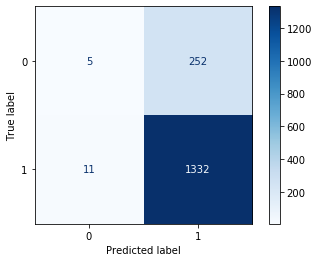

In [38]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model_best_params, X_val, y_val, cmap=plt.cm.Blues)  
plt.show() 